# Shapによるモデルの解釈

このノートブックでは、[shap](https://shap.readthedocs.io/en/latest/)を用いたモデルの解釈方法を紹介します。最初に、ロジスティック回帰で試した後、RNNモデルに取り組みます。

## パッケージのインストール

In [1]:
!pip install shap==0.39.0

     |████████████████████████████████| 356 kB 13.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=c0f40cc5f551159845fb59c94d3d3e3f792a21baf4f19a613cfc05f7ed63bf25
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


## ロジスティック回帰モデルの説明

まずは、ロジスティック回帰を用いて、分類器を作成します。データセットとしてはIMDBを使います。

### インポート

In [2]:
import numpy as np
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### データセットの読み込みとベクトル化

In [3]:
X, y = shap.datasets.imdb()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10, stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### モデルの学習

In [4]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8654

### 線形モデルの説明

モデルの学習を終えたので、SHAP値を計算しましょう。線形モデルに対して計算する場合には`LinearExplainer`を使います。

In [6]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # プロット用の関数には密なベクトルを渡す必要がある

どの特徴がモデルにとって重要であるかを把握するために、すべてのサンプルに対して、`summary_plot`を使って、各特徴のSHAP値をプロットできます。

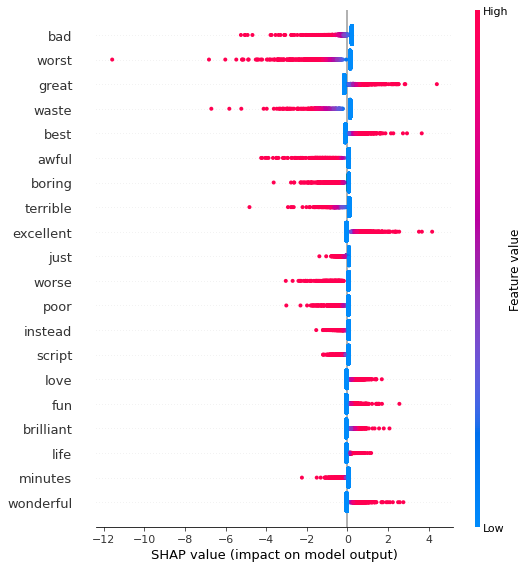

In [7]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

上の図は、全サンプルのSHAP値の大きさの合計で特徴をソートし、各特徴がモデルの出力に与える影響の分布を示しています。重要な特徴ほど上に位置していると考えてください。水平方向の分布は、右側にいくほど寄与が正の向きに大きく、左側にいくほど寄与が負の向きに大きくなることを示しています。色は特徴の値の大きさを示しており、赤であれば大きく、青であれば小さいという意味になります。たとえば、「bad」をみると、赤色の点（badのTF-IDF値が大きい）がSHAP値の負のほうに多く存在します。これは、「bad」という単語が出現すると、ネガティブだと予測しやすいモデルになっていることを表しています。

続いて、`force_plot`を用いて、1つの入力データに対する予測結果の解釈を得ましょう。

In [8]:
shap.initjs()
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


print(model.predict_proba(X_test[ind])[0][1])  # ポジティブの予測確率
print(sigmoid(3.46)) # f(x) = 3.46にシグモイド関数を適用した値

0.9696212217676419
0.9695279667353559


上の図では、基準値`base value`（渡した学習データセットの平均的なモデルの出力）からモデルの出力を`f(x)`まで押し上げるのに各特徴がどれだけ貢献しているかを示しています。予測を高くする特徴は赤で、予測を低くする特徴は青で示されています。たとえば、「entertaining」「performances」「best」は出力値に対してポジティブな方向への寄与がある一方、「tries」に関してはネガティブな方向への寄与があるという見方になります。基準値などの詳細については、以下の論文を参照してください。

- [A Unified Approach to Interpreting Model Predictions](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)



## RNNモデルの説明

次に、RNNモデルに対して説明を生成します。データの読み込みからモデルの学習まで、一気に実行してしまいましょう。

In [10]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

max_features = 20000
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Train...')
model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=2,
    validation_data=(x_test, y_test)
)
score, acc = model.evaluate(
    x_test,
    y_test,
    batch_size=batch_size
)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

Instructions for updating:
non-resource variables are not supported in the long term
Loading data...
17473536/17464789 [==============================] - 1s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
Build model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - ETA: 0s - loss: 0.4597 - acc: 0.7857

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


25000/25000 [==============================] - 120s 5ms/sample - loss: 0.4597 - acc: 0.7857 - val_loss: 0.3959 - val_acc: 0.8208
Epoch 2/2
25000/25000 [==============================] - 119s 5ms/sample - loss: 0.2965 - acc: 0.8792 - val_loss: 0.3957 - val_acc: 0.8305
Test score: 0.3957499202156067
Test accuracy: 0.83051997423172


線形モデルに対しては`LinearExplainer`を使いましたが、TensorFlowのモデルに対して説明を生成する場合は`DeepExplainer`を使います。

In [11]:
# 学習データの最初の100件を使う
explainer = shap.DeepExplainer(model, x_train[:100])

# 最初の10件の予測を説明
shap_values = explainer.shap_values(x_test[:10])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


`force_plot`を使って可視化してみましょう。

In [12]:
shap.initjs()

# インデックスから単語へのマッピングを作成
words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0])

1654784/1641221 [==============================] - 0s 0us/step
